In [1]:
import sys
sys.path.append("../vitamin_c/")
import load_data
import time
import json
import numpy as np
#import vitamin_c_new
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def get_param_index(all_pars,pars,sky_extra=None):
    """ 
    Get the list index of requested source parameter types                                                                                                               
    """
    # identify the indices of wrapped and non-wrapped parameters - clunky code                                                                                           
    mask = []
    idx = []

    # loop over inference params                                                                                                                                         
    for i,p in enumerate(all_pars):

        # loop over wrapped params                                                                                                                                       
        flag = False
        for q in pars:
            if p==q:
                flag = True    # if inf params is a wrapped param set flag                                                                                               

        # record the true/false value for this inference param                                                                                                           
        if flag==True:
            mask.append(True)
            idx.append(i)
        elif flag==False:
            mask.append(False)

    if sky_extra is not None:
        if sky_extra:
            mask.append(True)
            idx.append(len(all_pars))
        else:
            mask.append(False)

    return mask, idx, np.sum(mask)

In [3]:
params = '../vitamin_c/params_files/params.json'
bounds = '../vitamin_c/params_files/bounds.json'
fixed_vals = '../vitamin_c/params_files/fixed_vals.json'
run = time.strftime('%y-%m-%d-%X-%Z')
EPS = 1e-3

# Load parameters files                                                                                                                                                  
with open(params, 'r') as fp:
    params = json.load(fp)
with open(bounds, 'r') as fp:
    bounds = json.load(fp)
with open(fixed_vals, 'r') as fp:
    fixed_vals = json.load(fp)

# if doing hour angle, use hour angle bounds on RA                                                                                                                      \
                                                                                                                                                                         
bounds['ra_min'] = load_data.convert_ra_to_hour_angle(bounds['ra_min'],params,None,single=True)
bounds['ra_max'] = load_data.convert_ra_to_hour_angle(bounds['ra_max'],params,None,single=True)
print('... converted RA bounds to hour angle')
masks = {}
masks["inf_ol_mask"], masks["inf_ol_idx"], masks["inf_ol_len"] = get_param_index(params['inf_pars'],params['bilby_pars'])
masks["bilby_ol_mask"], masks["bilby_ol_idx"], masks["bilby_ol_len"] = get_param_index(params['bilby_pars'],params['inf_pars'])

masks["vonmise_mask"], masks["vonmise_idx_mask"], masks["vonmise_len"] = get_param_index(params['inf_pars'],params['vonmise_pars'])
masks["gauss_mask"], masks["gauss_idx_mask"], masks["gauss_len"] = get_param_index(params['inf_pars'],params['gauss_pars'])
masks["sky_mask"], masks["sky_idx_mask"], masks["sky_len"] = get_param_index(params['inf_pars'],params['sky_pars'])
masks["ra_mask"], masks["ra_idx_mask"], masks["ra_len"] = get_param_index(params['inf_pars'],['ra'])
masks["dec_mask"], masks["dec_idx_mask"], masks["dec_len"] = get_param_index(params['inf_pars'],['dec'])
masks["m1_mask"], masks["m1_idx_mask"], masks["m1_len"] = get_param_index(params['inf_pars'],['mass_1'])
masks["m2_mask"], masks["m2_idx_mask"], masks["m2_len"] = get_param_index(params['inf_pars'],['mass_2'])
#idx_mask = np.argsort(gauss_idx_mask + vonmise_idx_mask + m1_idx_mask + m2_idx_mask + sky_idx_mask) # + dist_idx_mask)                                                 \
                                                                                                                                                                         
masks["idx_mask"] = np.argsort(masks["m1_idx_mask"] + masks["m2_idx_mask"] + masks["gauss_idx_mask"] + masks["vonmise_idx_mask"]) # + sky_idx_mask)                     \
                                                                                                                                                                         
masks["dist_mask"], masks["dist_idx_mask"], masks["dis_len"] = get_param_index(params['inf_pars'],['luminosity_distance'])
masks["not_dist_mask"], masks["not_dist_idx_mask"], masks["not_dist_len"] = get_param_index(params['inf_pars'],['mass_1','mass_2','psi','phase','geocent_time','theta_jn\
','ra','dec','a_1','a_2','tilt_1','tilt_2','phi_12','phi_jl'])
masks["phase_mask"], masks["phase_idx_mask"], masks["phase_len"] = get_param_index(params['inf_pars'],['phase'])
masks["not_phase_mask"], masks["not_phase_idx_mask"], masks["not_phase_len"] = get_param_index(params['inf_pars'],['mass_1','mass_2','luminosity_distance','psi','geocen\
t_time','theta_jn','ra','dec','a_1','a_2','tilt_1','tilt_2','phi_12','phi_jl'])
masks["geocent_mask"], masks["geocent_idx_mask"], masks["geocent_len"] = get_param_index(params['inf_pars'],['geocent_time'])
masks["not_geocent_mask"], masks["not_geocent_idx_mask"], masks["not_geocent_len"] = get_param_index(params['inf_pars'],['mass_1','mass_2','luminosity_distance','psi','\
phase','theta_jn','ra','dec','a_1','a_2','tilt_1','tilt_2','phi_12','phi_jl'])
masks["xyz_mask"], masks["xyz_idx_mask"], masks["xyz_len"] = get_param_index(params['inf_pars'],['luminosity_distance','ra','dec'])
masks["not_xyz_mask"], masks["not_xyz_idx_mask"], masks["not_xyz_len"] = get_param_index(params['inf_pars'],['mass_1','mass_2','psi','phase','geocent_time','theta_jn','\
a_1','a_2','tilt_1','tilt_2','phi_12','phi_jl'])
masks["periodic_mask"], masks["periodic_idx_mask"], masks["periodic_len"] = get_param_index(params['inf_pars'],['ra','phase','psi','phi_12','phi_jl'])
masks["nonperiodic_mask"], masks["nonperiodic_idx_mask"], masks["nonperiodic_len"] = get_param_index(params['inf_pars'],['mass_1','mass_2','luminosity_distance','geocen\
t_time','theta_jn','dec','a_1','a_2','tilt_1','tilt_2'])
masks["idx_xyz_mask"] = np.argsort(masks["xyz_idx_mask"] + masks["not_xyz_idx_mask"])
masks["idx_dist_mask"] = np.argsort(masks["not_dist_idx_mask"] + masks["dist_idx_mask"])
masks["idx_phase_mask"] = np.argsort(masks["not_phase_idx_mask"] + masks["phase_idx_mask"])
masks["idx_geocent_mask"] = np.argsort(masks["not_geocent_idx_mask"] + masks["geocent_idx_mask"])
masks["idx_periodic_mask"] = np.argsort(masks["nonperiodic_idx_mask"] + masks["periodic_idx_mask"])

... converted RA bounds to hour angle


In [19]:
x_data_train, y_data_train, _, snrs_train = load_data.load_data(params,bounds,fixed_vals,params['train_set_dir'],params['inf_pars'])

...... shuffled filenames since we are loading in by chunks
...... Loaded file /home/joseph.bayley/data/CBC/O4MDC/training_sets_realnoise_2det_15par_256Hz/tset_tot-1000000_split-1000/data_537000-1000000.h5py
...... Loaded file /home/joseph.bayley/data/CBC/O4MDC/training_sets_realnoise_2det_15par_256Hz/tset_tot-1000000_split-1000/data_446000-1000000.h5py
...... Loaded file /home/joseph.bayley/data/CBC/O4MDC/training_sets_realnoise_2det_15par_256Hz/tset_tot-1000000_split-1000/data_274000-1000000.h5py
...... Loaded file /home/joseph.bayley/data/CBC/O4MDC/training_sets_realnoise_2det_15par_256Hz/tset_tot-1000000_split-1000/data_341000-1000000.h5py
...... Loaded file /home/joseph.bayley/data/CBC/O4MDC/training_sets_realnoise_2det_15par_256Hz/tset_tot-1000000_split-1000/data_55000-1000000.h5py
...... Loaded file /home/joseph.bayley/data/CBC/O4MDC/training_sets_realnoise_2det_15par_256Hz/tset_tot-1000000_split-1000/data_795000-1000000.h5py
...... Loaded file /home/joseph.bayley/data/CBC/O4MDC

In [4]:
train_dataset = load_data.DataLoader(params["train_set_dir"],params = params,bounds = bounds, masks = masks,fixed_vals = fixed_vals, chunk_batch = 40)

In [5]:
train_dataset.load_next_chunk()

../vitamin_c/load_data.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data['x_data'] = np.concatenate(np.array(data['x_data']), axis=0).squeeze()
../vitamin_c/load_data.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data['y_data_noisefree'] = np.transpose(np.concatenate(np.array(data['y_data_noisefree']), axis=0),[0,2,1])
../vitamin_c/load_data.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

load_time chunk 0: 4.12139368057251


In [7]:
x_data_train[0]

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([0.20608185, 0.19916147, 0.7957389 , 0.69526124, 0.40395668,
       0.36874387, 0.14447838, 0.31026953, 0.24339801, 0.55638313,
       0.32989937, 0.7477706 , 0.72014666, 0.6559628 , 0.36226347],
      dtype=float32)>

In [8]:
train_dataset.X[0]

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([0.20608185, 0.19916147, 0.92871284, 0.06945014, 0.57381654,
       0.36874387, 0.14447838, 0.31026953, 0.24339801, 0.55638313,
       0.32989937, 0.7477706 , 0.72014666, 0.6559628 , 0.36226347],
      dtype=float32)>

In [9]:
y_normscale = tf.cast(params['y_normscale'], dtype=tf.float32)
noiseamp = 1
y_data_train = (y_data_train + noiseamp*tf.random.normal(shape=tf.shape(y_data_train), mean=0.0, stddev=1.0, dtype=tf.float32))/y_normscale

In [9]:
np.shape(train_dataset.X[::100,1])

TensorShape([205])

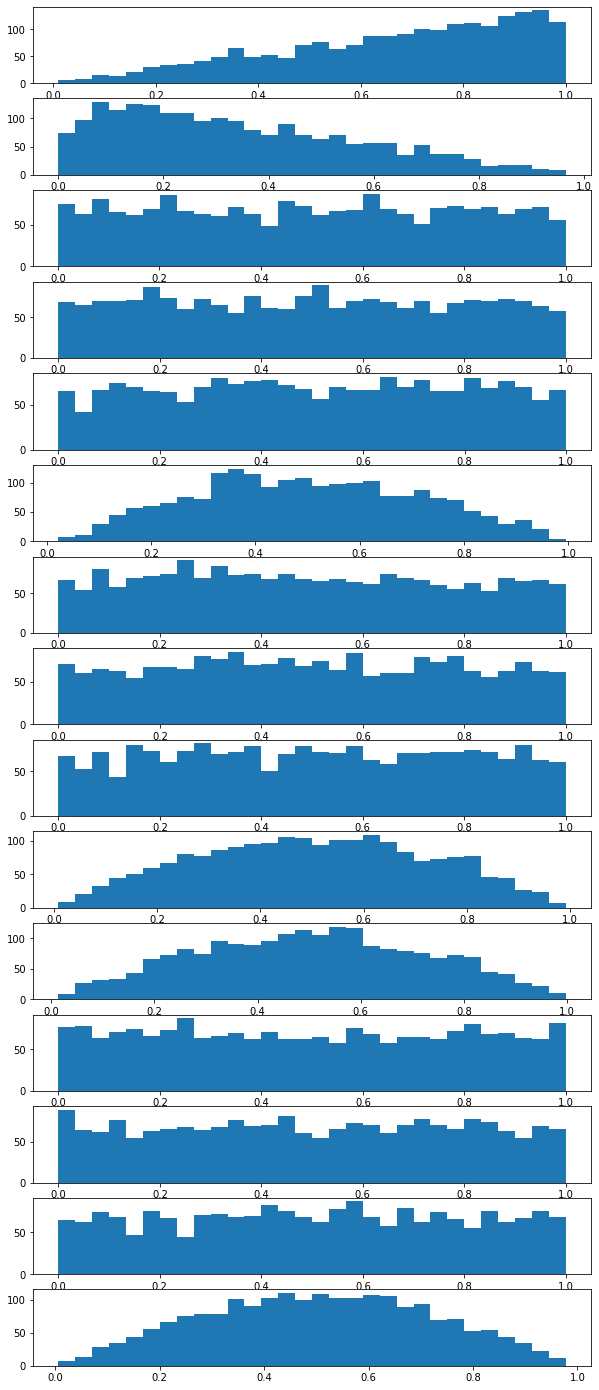

In [18]:
numpar = len(train_dataset.X[0])
fig, ax = plt.subplots(nrows = numpar, figsize = (10,25))
for i in range(numpar):
    ax[i].hist(np.array(train_dataset.X[::10,i]),bins = 30)

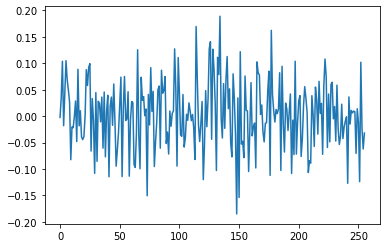

In [29]:
fig, ax = plt.subplots()
ind = 94
#ax.plot(y_data_train[ind][:,0])
ax.plot(train_dataset.Y_noisefree[ind][:,0])

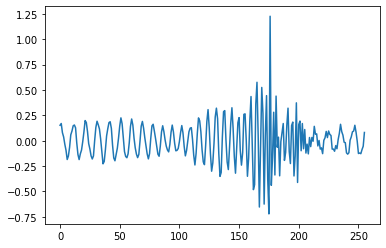

In [10]:
fig, ax = plt.subplots()
ax.plot(y_data_train[0][:,0] - train_dataset.Y_noisefree[0][:,0])